# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [1]:
# libraries
import torch
import random
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils
import BAAnet
import DecoderModule

### Process Endovis 2018 Dataset

In [2]:
# get dataloaders and display test images
batch_size = 8
reduce_factor = 4 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

# n = 2
# cmap = plt.get_cmap('Paired',12)
# cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
# cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
#                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]


# fig, axes = plt.subplots(n, 2, figsize=(20, 20))
# for i in range(n):  # Flatten the 2D array of axes
#     axes[i,0].imshow(images[i].permute(1, 2, 0))  
#     #axes[i,1].imshow(labels[i].permute(1, 2, 0))
#     label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
#     im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
#     # colorbar settings
#     cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
#     cbar.set_label("Segmentation Labels", fontsize=10)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels(cbar_labels)

# plt.tight_layout()
# plt.show()

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (320, 256)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


In [3]:
# check encoder and BBA
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
label = labels[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,160]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model = DecoderModule.DecoderModule([24,32,64,64])
img = model(y1,y2,y3,y4)
print()
print("Decoder:", img.shape)


model_BBA = BAAnet.BAANet_BBA_Only()
out = model_BBA(input)
print()
print("BAA_Only:", out.shape)

model_full = BAAnet.BAANet()
out = model_full(input)
print()
print("BAAnet Full:", out.shape)

c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


x0: torch.Size([1, 3, 320, 256])
x1: torch.Size([1, 24, 80, 64])
x2: torch.Size([1, 32, 40, 32])
x3: torch.Size([1, 64, 20, 16])
x4: torch.Size([1, 160, 10, 8])

y1: torch.Size([1, 24, 80, 64])
y2: torch.Size([1, 32, 40, 32])
y3: torch.Size([1, 64, 20, 16])
y4: torch.Size([1, 64, 20, 16])
x_baf3: torch.Size([1, 64, 40, 32])
x_baf2: torch.Size([1, 32, 80, 64])
x_baf1: torch.Size([1, 24, 80, 64])

Decoder: torch.Size([1, 12, 320, 256])

BAA_Only: torch.Size([1, 12, 320, 256])
x_baf3: torch.Size([1, 64, 40, 32])
x_baf2: torch.Size([1, 32, 80, 64])
x_baf1: torch.Size([1, 24, 80, 64])

BAAnet Full: torch.Size([1, 12, 320, 256])


## Create Model and Hyperparameters


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 5
lr = 1e-4

model = BAAnet.BAANet_BBA_Only().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
#criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) # learning rate scheduler

cuda:0


In [6]:
for i in range(epochs):
    TrainingUtils.train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler, i+1, device)

0it [00:00, ?it/s]c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
205it [04:55,  1.44s/it]
75it [11:09,  8.92s/it]


Epoch 1: Training Loss = 2.1338340246592176, mDICE: 0.5974454580904045, mIoU: 0.5741338059124684 mDICE Robot: 0.5482593439189326, mIoU Robot: 0.4205829661659469


12it [00:15,  1.26s/it]


KeyboardInterrupt: 

In [7]:
m_dice, m_iou = TrainingUtils.test(model, test_dataloader, device)
print(f"Mean DICE Score: {m_dice}")
print(f"Mean IoU Score: {m_iou}")

125it [19:08,  9.19s/it]

Mean DICE Score: 0.6299591169627848
Mean IoU Score: 0.5979468807151471


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9814326..2.9442186].
C:\Users\samee\AppData\Local\Temp\ipykernel_55268\3025710904.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 6 Axes> than <Figure size 1500x1500 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)


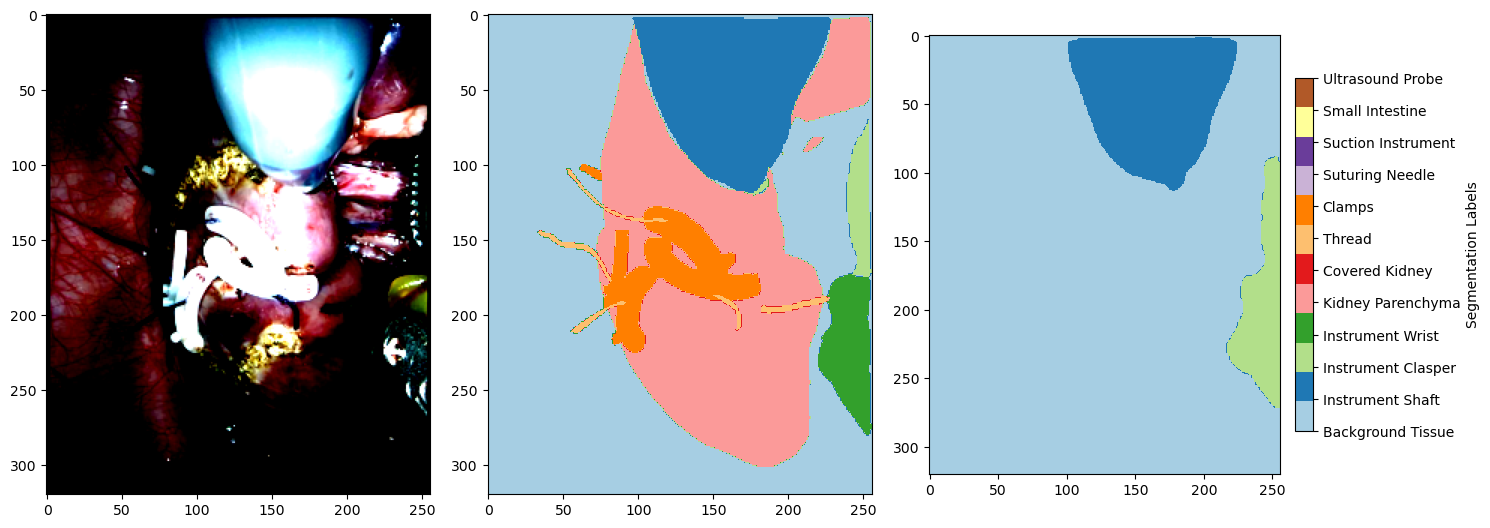

In [ ]:
# display model outputs
model.cpu()
i = 7 # 0 to batch_size
input = images[i:i+1]
label = labels[i:i+1]

predict = model(input) # predict image
predict = torch.argmax(predict, dim=1) # get grayscale prediction
predict = torch.eye(12, device=predict.device)[predict].permute(0,3,1,2)
predict = torch.nn.functional.interpolate(predict.float(), size=label.shape[2:], mode="nearest-exact")  # Match label size
prediction = EndovisDataloader.convert_masks_to_gray(predict.squeeze(0))

label = EndovisDataloader.convert_masks_to_gray(label.squeeze(0))

cmap = plt.get_cmap('Paired',12)
cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
               "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes[0].imshow(input.squeeze(0).permute(1, 2, 0))
axes[1].imshow(label, cmap = cmap, vmin = 0, vmax = 11)
axes[2].imshow(prediction, cmap = cmap, vmin = 0, vmax = 11)

cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label("Segmentation Labels", fontsize=10)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_labels)


plt.tight_layout()
plt.show()